In [31]:
# from keras.layers import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from keras.utils import to_categorical, plot_model
from tqdm.notebook import tqdm as tqdm
# from tensorflow.keras import Model
from keras.models import load_model
# from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.utils import shuffle
# from keras import models, layers, Model
from datetime import datetime
from keras import backend as K
from datetime import datetime
from Dental_Tool.data_processing import *
from Dental_Tool.Dental_Model import *
# from skimage import transform
# from skimage import io

import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np

import collections
import glob
import json
import cv2
import sys
import os

In [2]:
# mapping_data = json.load(open("Dental_Data/PBL/5_20200810/mapping.json", "r"))
# filter_data  = { path: int(state) for path, state in mapping_data.items() if int(state) >= 0 }
# filter_data  = { path: max(list(map(int, state))) for path, state in mapping_data.items() if max(list(map(int, state))) >= 0 }

In [3]:
# directory = [ "Major_10_clahe", "Major_10", "Major_10_clahe_Flip", "Major_10_Flip" ] 
# jsons = [ "Dental_Data/PBL/%s/mapping.json" % i for i in directory ]

# # "5_20200810", "5_20200810_Flip", "5_clahe_20200810", "5_clahe_20200810_Flip"

# mapping_clahe_data = json.load(open("Dental_Data/PBL/10_clahe_20200810/mapping.json", "r"))
# mapping_data = json.load(open("Dental_Data/PBL/10_20200810/mapping.json", "r"))

# mapping_clahe_data_Flip = json.load(open("Dental_Data/PBL/10_clahe_20200810_Flip/mapping.json", "r"))
# mapping_data_Flip = json.load(open("Dental_Data/PBL/10_20200810_Flip/mapping.json", "r"))


# filter_normal_data       = { path: max(list(map(int, state))) for path, state in mapping_data.items() if max(list(map(int, state))) >= 0 }
# filter_normal_data_Flip  = { path: max(list(map(int, state))) for path, state in mapping_data_Flip.items() if max(list(map(int, state))) >= 0 }

# filter_clahe_data        = { path: max(list(map(int, state))) for path, state in mapping_clahe_data.items() if max(list(map(int, state))) >= 0 }
# filter_clahe_data_Flip   = { path: max(list(map(int, state))) for path, state in mapping_clahe_data_Flip.items() if max(list(map(int, state))) >= 0 }


# filter_data = collections.OrderedDict()

# for normal, normal_flip, clahe, clahe_flip in zip(filter_normal_data.keys(), filter_normal_data_Flip.keys(), filter_clahe_data.keys(), filter_clahe_data_Flip.keys()):
#         filter_data[normal]      = filter_normal_data[normal]
#         filter_data[normal_flip] = filter_normal_data_Flip[normal_flip]
#         filter_data[clahe]       = filter_clahe_data[clahe]
#         filter_data[clahe_flip]  = filter_clahe_data_Flip[clahe_flip]

In [4]:
# def json_2_dataframe_PBL(dataframe, data):
#         data_dict, counter = collections.OrderedDict(), 0
        
#         multi_root = [1, 2, 3, 14, 15, 16, 17, 18, 19, 30, 31, 32]
#         less_data  = [1, 16, 17, 32]
        
#         for path, state in tqdm(data.items()):
# #                 item = { "Path": path, "State": state, "Class": state }
#                 item = { "Path": path, "State": state, "Class": state-1 if state > 1 else 0  }
#                 path_split = path.split("_")
#                 item["tooth_num"] = int(path_split[-2])
# #                 if item["tooth_num"] in multi_root: continue
# #                 item["tooth_num"] =  int(path_split[4]) if str.isdigit(path_split[4]) else int(path_split[5])
#                 item["angle"] = int(path_split[-1].split(".")[0])
# #                 item["tooth_num"] =  int(path_split[5]) if str.isdigit(path_split[5]) else int(path_split[6])
# #                 item["angle"] = int(path_split[-2])
#                 data_dict[counter] = item
#                 counter += 1        
#         dataframe = dataframe.from_dict(data_dict, "index")
#         return dataframe

    
    
# PBL_Columns = ["Path", "State", "Class"]
# dataset = pd.DataFrame(columns=PBL_Columns)
# dataset = json_2_dataframe_PBL(dataset, filter_data)
# dataset

In [5]:
 def split_dataframe(dataframe, arguscale=20):
                data_volume = len(dataframe) // arguscale
                training_range = (0, int(round(data_volume * 0.6, 0)))
                valid_range    = (training_range[1], int(training_range[1] + round(data_volume * 0.2, 0)) )
                test_range     = (valid_range[1], int(valid_range[1] + round(data_volume * 0.2, 0)))


                training_idx_range     = ( training_range[0] * arguscale, training_range[1] * arguscale )
                valid_idx_range        = ( valid_range[0] * arguscale   , valid_range[1]    * arguscale )
                test_idx_range         = ( test_range[0] * arguscale    , test_range[1]     * arguscale )

                train_data = dataframe.iloc[training_idx_range[0]:training_idx_range[1], :].reset_index(drop=True)
                valid_data = dataframe.iloc[valid_idx_range[0]:valid_idx_range[1], :].reset_index(drop=True)
                test_data  = dataframe.iloc[test_idx_range[0]:, :].reset_index(drop=True)

                train_data = shuffle(train_data).reset_index(drop=True)
                valid_data = shuffle(valid_data).reset_index(drop=True)
                test_data  = shuffle(test_data).reset_index(drop=True)

                return train_data, valid_data, test_data  

class DataGenerator(keras.utils.Sequence):
        'Generates data for Keras'
        def __init__(self, list_IDs, labels, batch_size=32, dim=(256, 256), n_channels=1,
                     n_classes=10, shuffle=True, resize_setting=(256, 256), Flip=True):
                'Initialization'
                self.dim = dim
                self.batch_size = batch_size // 2 if Flip else batch_size
                self.labels = labels
                self.list_IDs = list(list_IDs)
                self.n_channels = n_channels
                self.n_classes = n_classes
                self.shuffle = shuffle
                self.on_epoch_end()
                self.resize_setting = resize_setting
                self.Flip = Flip

        def __len__(self):
                'Denotes the number of batches per epoch'
                return int(np.ceil(len(self.list_IDs) / self.batch_size))

        def __getitem__(self, index):
                'Generate one batch of data'
                # Generate indexes of the batch
                end = (index+1)*self.batch_size if (index+1)*self.batch_size < len(self.indexes) else len(self.indexes)
                indexes = self.indexes[index*self.batch_size:end] 

                # Find list of IDs
                list_IDs_temp = [self.list_IDs[k] for k in indexes]         
                # Generate data
                X, y = self.__data_generation(list_IDs_temp)
               
                return X, y

        def on_epoch_end(self):
                'Updates indexes after each epoch'
                self.indexes = np.arange(len(self.list_IDs))
                if self.shuffle == True:
                        np.random.shuffle(self.indexes)

        def __data_generation(self, list_IDs_temp):
            
                # Initialization
                image_array_size = (
                                        self.batch_size * 2 if self.Flip else self.batch_size, 
                                        *self.dim,
                                        self.n_channels
                                   )
                X = np.zeros(image_array_size, dtype=np.uint8)
                y = np.array([0]* (self.batch_size * 2 if self.Flip else self.batch_size))
                
                for i, ID in enumerate(list_IDs_temp):
                        image = cv2.imread(ID, 0)
                        image = cv2.resize(image, (self.resize_setting[1], self.resize_setting[0]))
                        H_flip = cv2.flip(image, 1)

                        image = np.reshape(image, (*image.shape, 1))
                        H_flip = np.reshape(H_flip, (*H_flip.shape, 1))
                        
                        X[i,], y[i] =  image, self.labels[ID]
                        if self.Flip: X[i+self.batch_size], y[i+self.batch_size] = H_flip, self.labels[ID]
                        
                return X, to_categorical(y, num_classes=self.n_classes)
            
def generator(dataframe, arguscale=20, train_flip=True, valid_flip=True, test_flip=False, batch_size=32):
        
        stage_0 = dataset[dataset["State"] == 0]
        stage_1 = dataset[dataset["State"] == 1]
        stage_2 = dataset[dataset["State"] == 2]
        stage_3 = dataset[dataset["State"] == 3]
        
        train_data_0, valid_data_0, test_data_0 = split_dataframe(stage_0.reset_index(drop=True), arguscale=80) 
        train_data_1, valid_data_1, test_data_1 = split_dataframe(stage_1.reset_index(drop=True), arguscale=80) 
        train_data_2, valid_data_2, test_data_2 = split_dataframe(stage_2.reset_index(drop=True), arguscale=80) 
        train_data_3, valid_data_3, test_data_3 = split_dataframe(stage_3.reset_index(drop=True), arguscale=80) 
        
        train_min, valid_min, test_min = len(train_data_3), len(valid_data_3), len(test_data_3)
#         train_min, valid_min, test_min = len(train_data_2), len(valid_data_2), len(test_data_2)

        train_dataset   = pd.concat([train_data_0.iloc[:train_min//2, :], train_data_1.iloc[:train_min//2, :], 
                                     train_data_2.iloc[:train_min, :], train_data_3])
        
        valid_dataset   = pd.concat([valid_data_0.iloc[:valid_min//2, :], valid_data_1.iloc[:valid_min//2, :], 
                                     valid_data_2.iloc[:valid_min, :], valid_data_3])
        
        test_dataset    = pd.concat([test_data_0.iloc[:test_min//2, :] , test_data_1.iloc[:test_min//2, :] , 
                                     test_data_2.iloc[:test_min, :] , test_data_3 ])
                                         
        common_params = {
                              'batch_size': batch_size,
                              'n_classes' : len(np.unique(dataframe.Class)),
                              'n_channels': 1,
                              'shuffle'   : False,
                              'resize_setting': (200, 180),
                              'dim': (200, 180)
                 }
        
        train_param = { 'Flip': train_flip, **common_params }
        valid_param = { 'Flip': valid_flip, **common_params }
        test_param  = { 'Flip': test_flip , **common_params }
        
        train_dataset = shuffle(train_dataset)
        valid_dataset = shuffle(valid_dataset)
        test_dataset  = shuffle(test_dataset)
        
        train_dataset_dict = collections.OrderedDict(zip(train_dataset.Path, train_dataset.Class))
        valid_dataset_dict = collections.OrderedDict(zip(valid_dataset.Path, valid_dataset.Class))
        test_dataset_dict  = collections.OrderedDict(zip(test_dataset.Path, test_dataset.Class))
        

        train_generator = DataGenerator(train_dataset["Path"], train_dataset_dict ,**train_param)
        valid_generator = DataGenerator(valid_dataset["Path"], valid_dataset_dict ,**valid_param)
        test_generator  = DataGenerator(test_dataset ["Path"], test_dataset_dict  ,**test_param)
        
        return train_dataset, valid_dataset, test_dataset, train_generator, valid_generator, test_generator


def balance_data_generator(dataframe, argscale=20, train_flip=True, valid_flip=True, test_flip=False, batch_size=32):
        train_dataset, valid_dataset, test_dataset = balance_class_and_tooth(dataframe, argscale)
        common_params = {
                              'batch_size': batch_size,
                              'n_classes' : len(np.unique(dataframe.Class)),
                              'n_channels': 1,
                              'shuffle'   : False,
                              'resize_setting': (200, 180),
                              'dim': (200, 180)
                 }
        
        train_param = { 'Flip': train_flip, **common_params }
        valid_param = { 'Flip': valid_flip, **common_params }
        test_param  = { 'Flip': test_flip , **common_params }
        
        train_dataset = shuffle(train_dataset)
        valid_dataset = shuffle(valid_dataset)
        test_dataset  = shuffle(test_dataset)
        
        train_dataset_dict = collections.OrderedDict(zip(train_dataset.Path, train_dataset.Class))
        valid_dataset_dict = collections.OrderedDict(zip(valid_dataset.Path, valid_dataset.Class))
        test_dataset_dict  = collections.OrderedDict(zip(test_dataset.Path, test_dataset.Class))
        

        train_generator = DataGenerator(train_dataset["Path"], train_dataset_dict ,**train_param)
        valid_generator = DataGenerator(valid_dataset["Path"], valid_dataset_dict ,**valid_param)
        test_generator  = DataGenerator(test_dataset ["Path"], test_dataset_dict  ,**test_param)
        
        return train_dataset, valid_dataset, test_dataset, train_generator, valid_generator, test_generator
    
    
    
def balance_data_generator_from_path(data_frame_path, argscale=20, train_flip=True, valid_flip=True, test_flip=False, batch_size=32):
        train_dataset_path, valid_dataset_path, test_dataset_path = data_frame_path
        
        train_dataset   = pd.read_csv(train_dataset_path)
        valid_dataset   = pd.read_csv(valid_dataset_path)
        test_dataset    = pd.read_csv(test_dataset_path)
        
        
        common_params = {
                              'batch_size': batch_size,
                              'n_classes' : len(np.unique(train_dataset.Class)),
                              'n_channels': 1,
                              'shuffle'   : False,
                              'resize_setting': (200, 180),
                              'dim': (200, 180)
                 }
        
        train_param = { 'Flip': train_flip, **common_params }
        valid_param = { 'Flip': valid_flip, **common_params }
        test_param  = { 'Flip': test_flip , **common_params }
        
        train_dataset = shuffle(train_dataset)
        valid_dataset = shuffle(valid_dataset)
        test_dataset  = shuffle(test_dataset)
        
        train_dataset_dict = collections.OrderedDict(zip(train_dataset.Path, train_dataset.Class))
        valid_dataset_dict = collections.OrderedDict(zip(valid_dataset.Path, valid_dataset.Class))
        test_dataset_dict  = collections.OrderedDict(zip(test_dataset.Path, test_dataset.Class))
        

        train_generator = DataGenerator(train_dataset["Path"], train_dataset_dict ,**train_param)
        valid_generator = DataGenerator(valid_dataset["Path"], valid_dataset_dict ,**valid_param)
        test_generator  = DataGenerator(test_dataset ["Path"], test_dataset_dict  ,**test_param)
        
        return train_dataset, valid_dataset, test_dataset, train_generator, valid_generator, test_generator

In [6]:
def plot_result(history, output_dir):
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(16,5))
        
        plt.subplot(121)
        plt.title("Loss")
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label = 'Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='lower right')
        
        plt.subplot(122)
        plt.title("Accuracy")
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([0.1, 1.5])
        plt.legend(loc='lower right')
        
        target_dir = "Results/%s" % (output_dir)
        if not os.path.isdir(target_dir): os.makedirs(target_dir)
        plt.savefig("%s/history.png" % (target_dir))
        plt.show()
        
        
        
def plot_confusion_matrix(confusion_matrix, classes, acc, output_dir, idx):
        df_cm = pd.DataFrame(confusion_matrix, range(classes), range(classes))
        sns.set(font_scale=1.4)
        sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='YlGnBu', fmt='g') # font size
        plt.title("Confusion Matrix (Acc = {:5.2f}%)".format(acc))
        plt.xlabel('prediction' , fontsize=18)
        plt.ylabel('ground truth', fontsize=18)
        
        target_dir = "Results/%s/cmxs" % (output_dir)
        if not os.path.isdir(target_dir): os.makedirs(target_dir)
        plt.savefig("{}/cmx_acc_{:5.2f}.png".format(target_dir, acc), transparent=True, bbox_inches='tight', pad_inches=0 )
        
        plt.show()

In [7]:
# train_dataset, valid_dataset, test_dataset, train_generator, valid_generator, test_generator = balance_data_generator(dataset, argscale=80,train_flip=False, valid_flip=False, test_flip=False)
dataset_list = [
            "Results/Emsemble_20200824-094145/table/train_dataset.csv", 
            "Results/Emsemble_20200824-094145/table/valid_dataset.csv", 
            "Results/Emsemble_20200824-094145/table/test_dataset.csv"
          ]
train_dataset, valid_dataset, test_dataset, train_generator, valid_generator, test_generator = balance_data_generator_from_path(dataset_list, argscale=80, train_flip=False, valid_flip=False, test_flip=False)

In [8]:
# if not os.path.isdir("Results/%s/table" % root_dir) : os.makedirs("Results/%s/table" % root_dir)
# train_dataset.to_csv("Results/%s/table/train_dataset.csv" % root_dir, index=False)
# valid_dataset.to_csv("Results/%s/table/valid_dataset.csv" % root_dir, index=False)
# test_dataset.to_csv("Results/%s/table/test_dataset.csv"   % root_dir, index=False)

In [9]:
def CNN_Net(input_shape, classes):
        model = models.Sequential()
        
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        
        
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        
        
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
       
        
        model.add(Conv2D(256, (3, 3), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        
        
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(64, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(classes, activation='softmax'))
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=['accuracy'])
        
        return model
    
from keras.applications.inception_v3 import InceptionV3
def Inception(input_shape, classes):
        
        input_tensor = Input(shape=input_shape)
        base_model = InceptionV3(input_tensor=input_tensor, include_top=False, weights=None)
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024, activation='relu')(x)
        predictions = Dense(classes, activation='softmax')(x)

        model = Model(inputs=input_tensor, outputs=predictions)
        
        
                
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer='rmsprop',
#                       optimizer=keras.optimizers.Adadelta(),
                      metrics=['accuracy'])        
        return model
    
from keras.applications.resnet_v2 import ResNet50V2

def ResNet(input_shape, classes):
        
        input_tensor = Input(shape=input_shape)
        base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights=None)
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024, activation='relu')(x)
        predictions = Dense(classes, activation='softmax')(x)
        model = Model(inputs=input_tensor, outputs=predictions)
        model.compile(loss=keras.losses.categorical_crossentropy,  
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=['accuracy'])        
        return model

Epoch 1/30
1437/1437 [==============================] - 96s 67ms/step - loss: 0.8448 - accuracy: 0.6284 - val_loss: 0.7586 - val_accuracy: 0.6415

Epoch 00001: val_accuracy improved from -inf to 0.64153, saving model to Results/Emsemble_20200825-005230/CNN_Net_20200825-005231/parameter/weights-improvement-01-0.64.hdf5
Epoch 2/30
1437/1437 [==============================] - 94s 65ms/step - loss: 0.4837 - accuracy: 0.7999 - val_loss: 0.7529 - val_accuracy: 0.6884

Epoch 00002: val_accuracy improved from 0.64153 to 0.68837, saving model to Results/Emsemble_20200825-005230/CNN_Net_20200825-005231/parameter/weights-improvement-02-0.69.hdf5
Epoch 3/30
1437/1437 [==============================] - 93s 65ms/step - loss: 0.3007 - accuracy: 0.8839 - val_loss: 0.8223 - val_accuracy: 0.7472

Epoch 00003: val_accuracy improved from 0.68837 to 0.74718, saving model to Results/Emsemble_20200825-005230/CNN_Net_20200825-005231/parameter/weights-improvement-03-0.75.hdf5
Epoch 4/30
1437/1437 [============

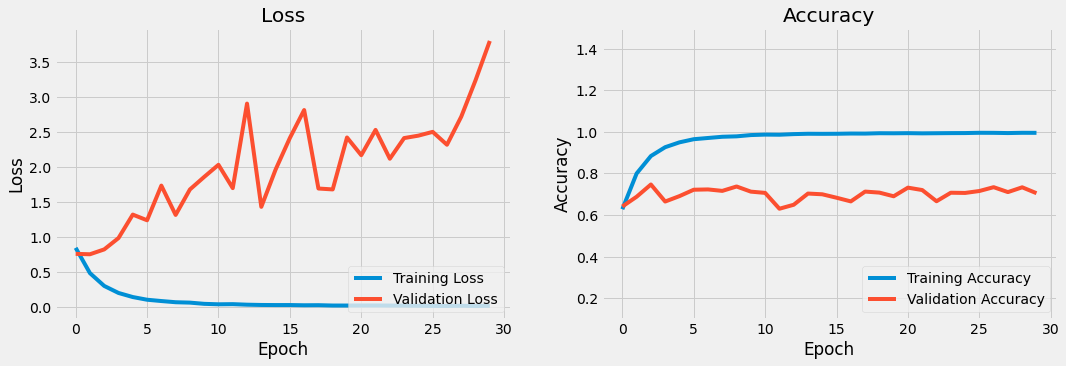

492/492 [==============================] - 23s 47ms/step
Accuracy  = 67.96 %


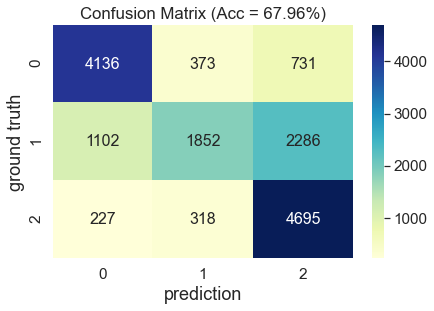

492/492 [==============================] - 23s 47ms/step
Accuracy  = 73.29 %


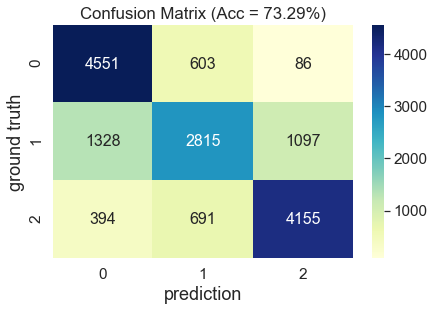

492/492 [==============================] - 23s 47ms/step
Accuracy  = 76.64 %


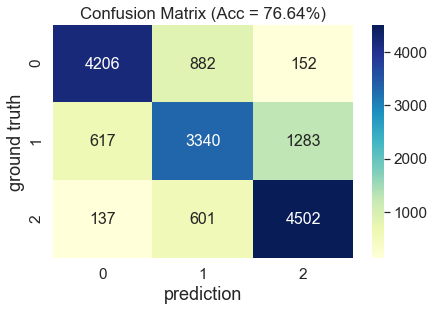

Epoch 1/30
1437/1437 [==============================] - 281s 196ms/step - loss: 0.8734 - accuracy: 0.5827 - val_loss: 1.4548 - val_accuracy: 0.4598

Epoch 00001: val_accuracy improved from -inf to 0.45981, saving model to Results/Emsemble_20200825-005230/Inception_20200825-014025/parameter/weights-improvement-01-0.46.hdf5
Epoch 2/30
1437/1437 [==============================] - 264s 183ms/step - loss: 0.5055 - accuracy: 0.7869 - val_loss: 0.8389 - val_accuracy: 0.7146

Epoch 00002: val_accuracy improved from 0.45981 to 0.71458, saving model to Results/Emsemble_20200825-005230/Inception_20200825-014025/parameter/weights-improvement-02-0.71.hdf5
Epoch 3/30
1437/1437 [==============================] - 262s 182ms/step - loss: 0.3364 - accuracy: 0.8671 - val_loss: 0.5221 - val_accuracy: 0.7259

Epoch 00003: val_accuracy improved from 0.71458 to 0.72594, saving model to Results/Emsemble_20200825-005230/Inception_20200825-014025/parameter/weights-improvement-03-0.73.hdf5
Epoch 4/30
1437/1437 [

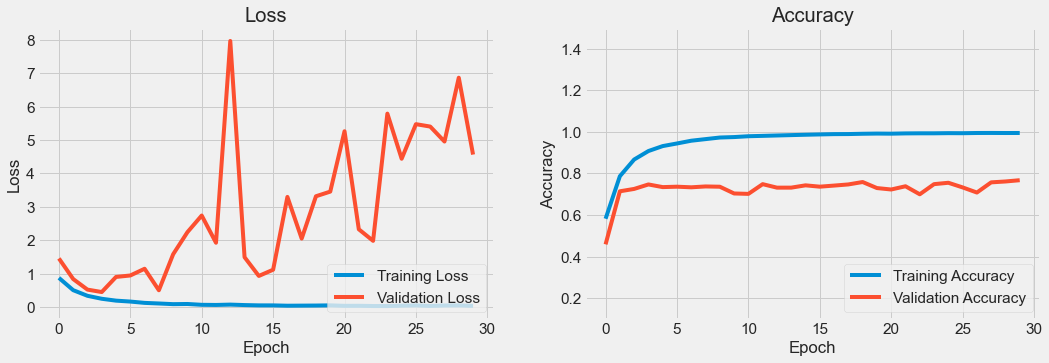

492/492 [==============================] - 26s 53ms/step
Accuracy  = 44.80 %


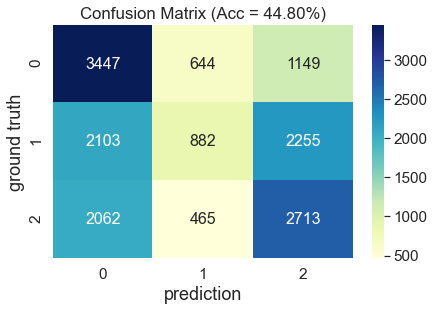

492/492 [==============================] - 26s 52ms/step
Accuracy  = 69.85 %


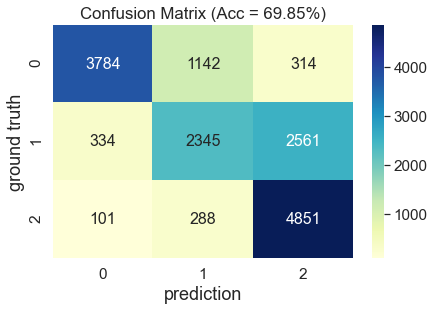

492/492 [==============================] - 29s 60ms/step
Accuracy  = 74.54 %


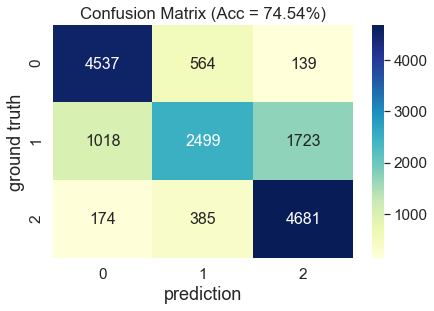

492/492 [==============================] - 39s 79ms/step
Accuracy  = 77.79 %


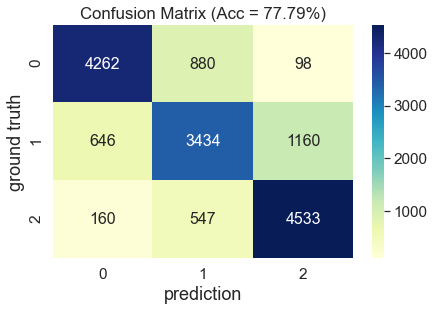

492/492 [==============================] - 51s 103ms/step
Accuracy  = 75.73 %


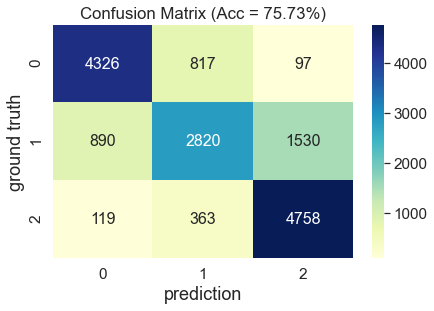

492/492 [==============================] - 62s 127ms/step
Accuracy  = 77.89 %


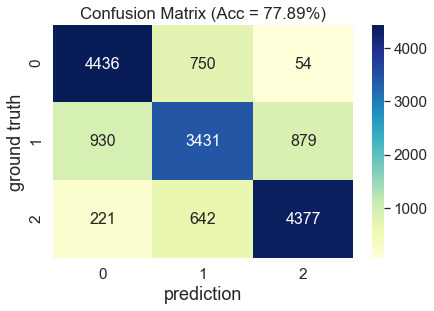

492/492 [==============================] - 78s 159ms/step
Accuracy  = 74.30 %


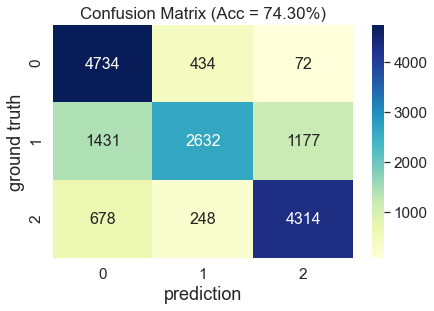

492/492 [==============================] - 78s 160ms/step
Accuracy  = 76.70 %


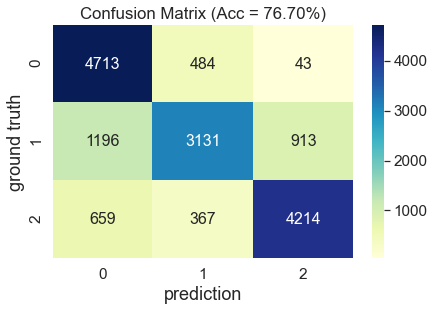

Epoch 1/30
1437/1437 [==============================] - 337s 235ms/step - loss: 0.7644 - accuracy: 0.6411 - val_loss: 0.9495 - val_accuracy: 0.5458

Epoch 00001: val_accuracy improved from -inf to 0.54577, saving model to Results/Emsemble_20200825-005230/ResNet_20200825-050805/parameter/weights-improvement-01-0.55.hdf5
Epoch 2/30
1437/1437 [==============================] - 318s 221ms/step - loss: 0.3750 - accuracy: 0.8480 - val_loss: 0.7509 - val_accuracy: 0.6003

Epoch 00002: val_accuracy improved from 0.54577 to 0.60034, saving model to Results/Emsemble_20200825-005230/ResNet_20200825-050805/parameter/weights-improvement-02-0.60.hdf5
Epoch 3/30
1437/1437 [==============================] - 318s 221ms/step - loss: 0.2180 - accuracy: 0.9168 - val_loss: 1.9961 - val_accuracy: 0.6993

Epoch 00003: val_accuracy improved from 0.60034 to 0.69933, saving model to Results/Emsemble_20200825-005230/ResNet_20200825-050805/parameter/weights-improvement-03-0.70.hdf5
Epoch 4/30
1437/1437 [=========

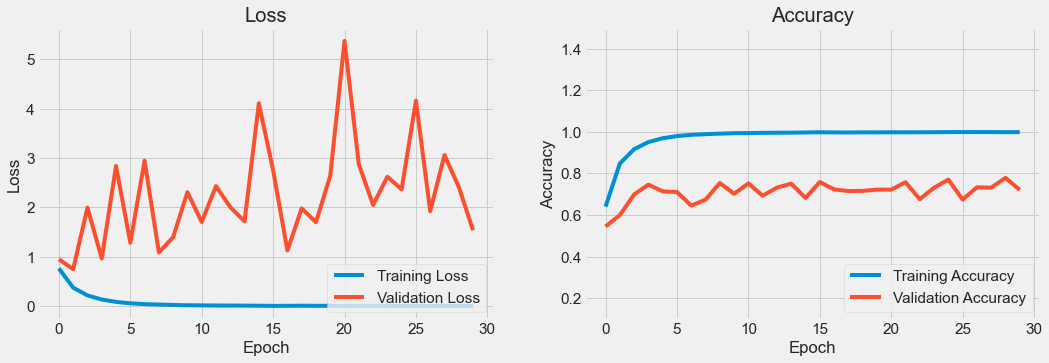

492/492 [==============================] - 39s 79ms/step
Accuracy  = 54.86 %


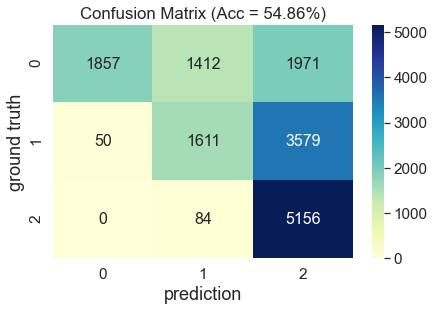

492/492 [==============================] - 59s 120ms/step
Accuracy  = 60.02 %


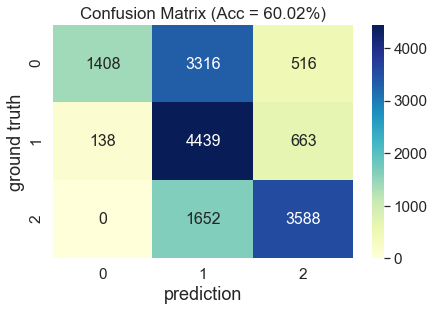

492/492 [==============================] - 59s 121ms/step
Accuracy  = 70.66 %


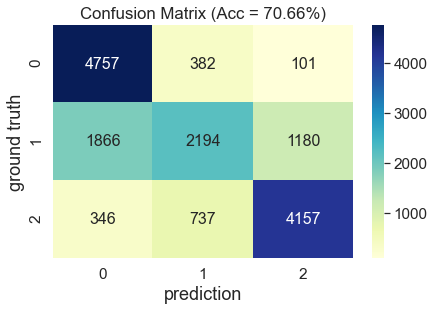

492/492 [==============================] - 59s 120ms/step
Accuracy  = 71.48 %


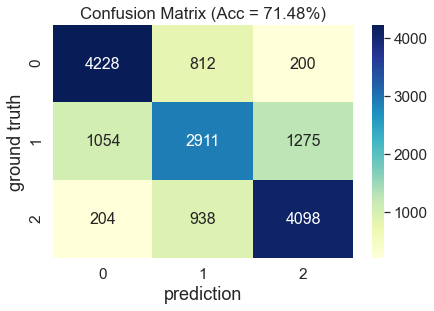

492/492 [==============================] - 64s 129ms/step
Accuracy  = 74.70 %


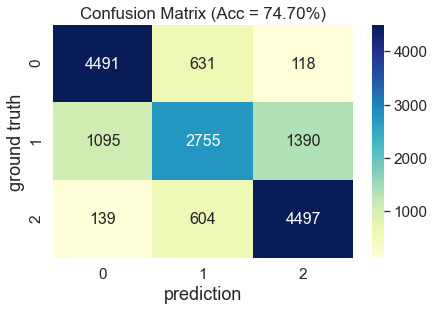

492/492 [==============================] - 62s 126ms/step
Accuracy  = 74.40 %


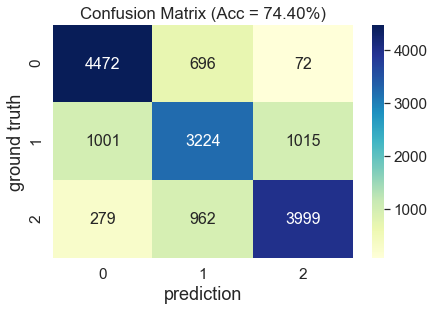

492/492 [==============================] - 67s 136ms/step
Accuracy  = 75.66 %


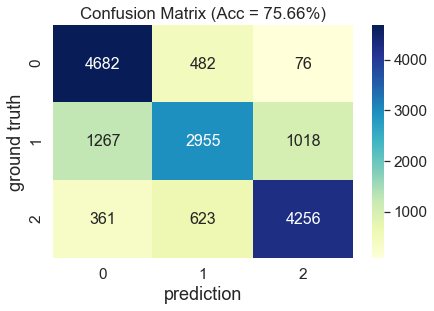

492/492 [==============================] - 67s 137ms/step
Accuracy  = 76.02 %


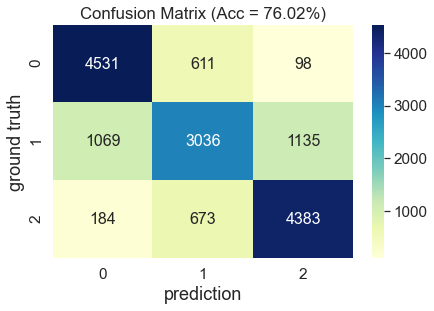

In [10]:
all_models = { "CNN_Net": CNN_Net, "Inception": Inception, "ResNet": ResNet }
root_dir  =  "Emsemble_" + datetime.now().strftime("%Y%m%d-%H%M%S")

best_models = []
for model_name, model_fnc in all_models.items():
        K.clear_session()
        model      = model_fnc(input_shape=(200, 180, 1), classes=len(np.unique(train_dataset["Class"])))
        epochs     = 30
        param_dir  = model_name + "_" + datetime.now().strftime("%Y%m%d-%H%M%S")
        
        if not os.path.isdir("Results/%s/%s/parameter" % (root_dir, param_dir) ) : 
                os.makedirs("Results/%s/%s/parameter"  % (root_dir, param_dir) )

        filepath="Results/%s/%s/parameter/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5" % (root_dir, param_dir)
        checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

        history = model.fit_generator(
                                generator=train_generator,
                                validation_data=valid_generator,
                                epochs=epochs,
                                workers=2,
                                shuffle=True,
                                verbose=1,
                                callbacks=[checkpoint]
                               )
        plot_result(history, "%s/%s" % (root_dir, param_dir))
        
        best_acc = -99.0
        best_param = ""

        idx = 0
        K.clear_session()
        for param in glob.iglob("Results/%s/%s/parameter/*" % (root_dir, param_dir) ):
                model = load_model(param)
                pred = model.predict_generator(test_generator, verbose=1)
                pred = np.argmax(pred, axis=1)
                pred = pred[:len(test_dataset.Class)]
                y = test_dataset.Class
                confusion = confusion_matrix(y, pred)
                curr_acc = (pred == y).mean() * 100
                if curr_acc > best_acc: 
                        best_param = param
                        best_acc = curr_acc
                title = "Accuracy  = {:5.2f} %".format(curr_acc)
                print(title)
                
                # change save dir !!
                plot_confusion_matrix(confusion, len(np.unique(test_dataset.Class)), curr_acc, "%s/%s" % (root_dir, param_dir), idx)
                idx += 1
                K.clear_session()
                
        best_models.append( (best_param, best_acc) )      

In [11]:
best_models

[('Results/Emsemble_20200825-005230/CNN_Net_20200825-005231/parameter\\weights-improvement-03-0.75.hdf5',
  76.6412213740458),
 ('Results/Emsemble_20200825-005230/Inception_20200825-014025/parameter\\weights-improvement-19-0.76.hdf5',
  77.8880407124682),
 ('Results/Emsemble_20200825-005230/ResNet_20200825-050805/parameter\\weights-improvement-29-0.78.hdf5',
  76.0178117048346)]

In [12]:
train_results, valid_results, test_results = [], [], []
K.clear_session()
for best_param_path, acc in best_models:
        best_model = load_model(best_param_path)
        train_predict = best_model.predict_generator(train_generator, verbose=1 )
        train_predict = train_predict[:len(train_dataset)] # afraid 1433 * 32 ( on batch and batch , no half)
        train_result  = np.argmax(train_predict, axis=1)
        train_results.append(train_result)
        
        valid_predict = best_model.predict_generator(valid_generator, verbose=1)
        valid_predict = valid_predict[:len(valid_dataset)]
        valid_result  = np.argmax(valid_predict, axis=1)
        valid_results.append(valid_result)
        
        test_predict = best_model.predict_generator(test_generator, verbose=1)
        test_predict = test_predict[:len(test_dataset)]
        test_result  = np.argmax(test_predict, axis=1)
        test_results.append(test_result)
        K.clear_session()

492/492 [==============================] - 98s 200ms/step


In [29]:
def vote(dataframe, results):
        for idx, name in enumerate(all_models.keys()):
                dataframe[name] = results[idx]
        
        vote_results = [0] * len(dataframe)
        results = np.array(results).T
        no_majority_num = 0
        for idx, item in enumerate(results):
                item = list(item)
                ans = -99
                if item[0] == item[1] == item[2]: ans = item[0]
                elif item[0] == item[1] or item[1] == item[2] or item[0] == item[2]: ans = max(set(item), key = item.count)
                else: 
#                         print("No Majority!")
                        no_majority_num += 1
#                         ans = np.random.randint(3, size=1)[0]
                        ans = 1
                vote_results[idx] = ans
        print("# of no majority: %d" % no_majority_num )
        dataframe["Predict"] = vote_results
        return dataframe
    
train_dataset_vote = vote(train_dataset, train_results)
valid_dataset_vote = vote(valid_dataset, valid_results)
test_dataset_vote  = vote(test_dataset , test_results )

# of no majority: 34
# of no majority: 271
# of no majority: 248


Accuracy  = 79.96 %


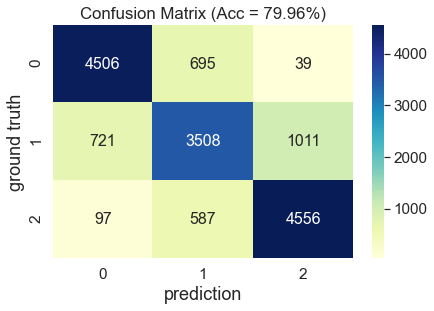

In [25]:
confusion = confusion_matrix(test_dataset_vote.Class, test_dataset_vote.Predict)
curr_acc = (test_dataset_vote.Class == test_dataset_vote.Predict).mean() * 100
if curr_acc > best_acc: 
        best_param = param
        best_acc = curr_acc
title = "Accuracy  = {:5.2f} %".format(curr_acc)
print(title)
plot_confusion_matrix(confusion, len(np.unique(test_dataset.Class)), curr_acc, "%s" % (root_dir), 0)

In [17]:
if not os.path.isdir("Results/%s/table" % root_dir) : os.makedirs("Results/%s/table" % root_dir)
train_dataset_vote.to_csv("Results/%s/table/train_predict_4_flip.csv" % root_dir, index=False)
valid_dataset_vote.to_csv("Results/%s/table/valid_predict_4_flip.csv" % root_dir, index=False)
test_dataset_vote.to_csv("Results/%s/table/test_predict_4_flip.csv"   % root_dir, index=False)

In [26]:
def statistic(dataframe):
        results = pd.DataFrame(columns=["Class 0", "Class 1", "Class 2"])
        for i in range(4):
                data = {
                    "Class 0": len(dataframe[(dataframe["State"]==i) & (dataframe["Predict"]==0)]),
                    "Class 1": len(dataframe[(dataframe["State"]==i) & (dataframe["Predict"]==1)]),
                    "Class 2": len(dataframe[(dataframe["State"]==i) & (dataframe["Predict"]==2)]),
                }
                
                total = data["Class 0"] + data["Class 1"] + data["Class 2"]
                if i <= 1: Acc = data["Class 0"] / total * 100
                if i == 2: Acc = data["Class 1"] / total * 100
                if i == 3: Acc = data["Class 2"] / total * 100

                data["Acc"] = "{}%".format(int(round(Acc,0)))
                results = results.append(data, ignore_index=True)
        return results

In [27]:
statistic(valid_dataset_vote)

,Class 0,Class 1,Class 2,Acc
0,2343,131,6,94%
1,2028,439,13,82%
2,817,3547,596,72%
3,42,779,4139,83%


In [28]:
statistic(test_dataset_vote)

,Class 0,Class 1,Class 2,Acc
0,2542,72,6,97%
1,1964,623,33,75%
2,721,3508,1011,67%
3,97,587,4556,87%


In [ ]:
# def gradcam(model, x, layer_name, image, GT, idx):
#         mapping = {0:'Healthy', 1:'Medium', 2:'Severe'}
        
#         preds = model.predict(x)
#         print('\nProbabilities:')
#         for i in range(3): print('\t{}. {}\t{:.3f}'.format(i, mapping[i], preds[0,i]))
#         pred_class = np.argmax(preds[0])
#         print("\nGround Truth is {} , Explanation for '{}':".format(mapping[GT], mapping[pred_class]))
        
#         pred_output = model.output
        
#         conv_layer = model.get_layer(layer_name)
# #         print(model.trainable_weights)
# #         print(pred_output)
# #         print(conv_layer.output)
#         grads = K.gradients(pred_output, conv_layer.output)
# #         print(grads)
        
        
# #         pooled_grads = K.sum(grads[0], axis=(0, 1, 2))
#         pooled_grads = K.sum(grads[0], axis=(0, 1, 2))
# #         print(pooled_grads)
#         iterate = K.function([model.input], [pooled_grads, conv_layer.output[0]])
#         pooled_grads_value, conv_layer_output_value = iterate([x])
        
        
#         for i in range(pooled_grads_value.shape[0]):
#                 conv_layer_output_value[:, :, i] *= (pooled_grads_value[i])
        
#         heatmap = np.sum(conv_layer_output_value, axis=-1)
#         image = image.astype(np.uint8)
#         image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
#         # ReLU
#         heatmap = np.maximum(heatmap, 0)
#         print(heatmap)
# #         num_nonzeros = np.count_nonzero(K.eval(heatmap)==0)
        
# #         if num_nonzeros < 0.8 * heatmap.shape[0] * heatmap.shape[1]: return False
        
#         # normalize
#         heatmap /= np.max(heatmap)
        
#         heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
#         heatmap = np.uint8(255 * heatmap)
        
        
        
#         plt.figure(figsize=(16,5))
#         plt.subplot(121)
#         plt.title("Original")
#         plt.imshow(image)
#         plt.xticks([]), plt.yticks([])
        
#         plt.subplot(122)
#         plt.title("Grad-CAM")
#         plt.xticks([]), plt.yticks([])
#         plt.imshow(image, alpha=0.7)
#         plt.imshow(heatmap, cmap='jet', alpha=0.3)
# #                 plt.savefig("%s/heatmap_%d.png" % (output_dir, idx))
#         plt.show()

#         return True


    
# Conv_layers = [ layer.name for layer in model.layers if 'conv' in layer.name ]
# path, truth, prediction = list(test_dataset["Path"]), list(test_dataset["Class"]), list(test_dataset["Predict"])
# same_generator = ( (path[idx], truth, pred) for idx, (truth, pred) in enumerate(zip(y, prediction)) if truth == pred )
# diff_generator = ( (path[idx], truth, pred) for idx, (truth, pred) in enumerate(zip(y, prediction)) if truth != pred )

In [ ]:
# heapmap_count = 0
# resize_setting = (200, 180)
# for idx, item in enumerate(same_generator):
#         image_path, gt, pred = item
#         image = cv2.imread(image_path, 0)
#         image = cv2.resize(image, (resize_setting[1], resize_setting[0]) )
#         image = np.reshape(image, (*image.shape, 1))  
#         state = gradcam(model, image.reshape(1, *image.shape), Conv_layers[-1], image, gt, idx)
#         if state: heapmap_count += 1
# #                 print("Ground Truth: %d, Prediction: %d" % (gt, pred))
#         if heapmap_count >= 20: break

In [ ]:
# heapmap_count = 0
# resize_setting = (200, 180)
# for idx, item in enumerate(diff_generator):
#         image_path, gt, pred = item
#         image = cv2.imread(image_path, 0)
#         image = cv2.resize(image, (resize_setting[1], resize_setting[0]) )
#         image = np.reshape(image, (*image.shape, 1))
#         state = gradcam(model, image.reshape(1, *image.shape), Conv_layers[-1], image, gt, idx)
#         if state: 
#                 heapmap_count += 1
#                 print("Ground Truth: %d, Prediction: %d" % (gt, pred))
#         if heapmap_count >= 20: break